# Overview
This notebook presents an end-to-end machine learning pipeline designed to compare glass-box and black-box approaches to predictive modeling. The pipeline integrates preprocessing, baseline modeling, feature selection, iterative refinement, and robustness evaluation, offering a systematic framework to balance interpretability and performance.

The workflow is structured as follows:

**I. Baseline SPLIT modeling**\
SPLIT is first trained with fixed parameters, establishing an interpretable reference point.

**II. XGBoost modeling and feature selection**\
XGBoost serves both as a black-box benchmark and as a feature selector. Cumulative-gain thresholds (80%, 90%, 95%, 97.5%, 99%) generate reduced feature sets for downstream testing.

**III. Refined SPLIT modeling**\
SPLIT is re-run on the selected subsets, with an extended parameter search (e.g., +20% max depth) to probe the interpretability–accuracy trade-off.

**IV. Stability check across seeds**\
The entire pipeline is repeated under three random seeds (42, 50, 99) to evaluate robustness and consistency.

Together, these steps provide a full-cycle experiment where interpretability-first models (SPLIT) are directly benchmarked against performance-first models (XGBoost), demonstrating the trade-offs and synergies between the two.

# Steps
1. Get stats about missing data points
2. Clean missing data points
3. Encode and binarize the labels
4. Split the test dataset between validation and test
5. Get the balance stats for each split
6. Run SMOTE
7. Run SPLIT -> lookahead depth = 2, max_depth = 5, lambda = 0.005, 0.006, 0.007, 0.008, 0.009, 0.01
8. Run XGBoost to select features -> baseline iteration, then cumulative gain = 80%, 90%, 95% , 97.5%, 99%
9. Run SPLIT with the selected features

## 1 and 2 - Get stats about missing data points, clean missing data points

In [1]:
import pandas as pd
import dimex as dx

RANDOM_SEED = 42

train_filename = '../airline-passenger-satisfaction/train.csv'
test_filename = '../airline-passenger-satisfaction/test.csv'

train_dataset = pd.read_csv(train_filename, index_col=0)
test_dataset = pd.read_csv(test_filename, index_col=0)

train_clean, train_missing_stats, train_clean_filename = dx.clean_missing(train_filename)
test_clean, test_missing_stats, test_clean_filename = dx.clean_missing(test_filename)

train_missing_stats = list(train_missing_stats.items())
test_missing_stats = list(test_missing_stats.items())

missing_tbl = []
missing_tbl.extend([{
    "dataset": "train",
    "size": len(train_dataset),
    train_missing_stats[0][0]: train_missing_stats[0][1],
    train_missing_stats[1][0]: format(train_missing_stats[1][1],".2%"),
}, {
    "dataset": "train",
    "size": len(test_dataset),
    test_missing_stats[0][0]: test_missing_stats[0][1],
    test_missing_stats[1][0]: format(test_missing_stats[1][1],".2%"),
},])

display(pd.DataFrame(missing_tbl))

Clean dataset saved to /mnt/c/Users/lucas/Documents/Externship/dimex/airline-passenger-satisfaction/train_clean.csv
Clean dataset saved to /mnt/c/Users/lucas/Documents/Externship/dimex/airline-passenger-satisfaction/test_clean.csv


,dataset,size,missing data points,% missing data points
0,train,103904,310,0.30%
1,train,25976,83,0.32%


## 3, 4, and 5 - Encode the features, binarize the labels, split the dataset, get the balance stats for each split

In [2]:
train_encoded, train_encoded_filename = dx.binarize_encode(train_clean_filename, "satisfied", "neutral or dissatisfied")
test_encoded, test_encoded_filename = dx.binarize_encode(test_clean_filename, "satisfied", "neutral or dissatisfied")

x_val, x_test, y_val, y_test = dx.split_dataset(test_encoded, test_size=2/3, random_state=RANDOM_SEED)

labels = train_encoded.columns[-1]
train_balance = dx.balance_stats(train_encoded[labels])
val_balance = dx.balance_stats(y_val)
test_balance = dx.balance_stats(y_test)

balance_stats = []
balance_stats.extend([{"dataset": "train",
                       "1": format(train_balance["1"], ".2%"),
                       "0": format(train_balance["0"], ".2%"),},
                      {"dataset": "validation",
                       "1": format(val_balance["1"], ".2%"),
                       "0": format(val_balance["0"], ".2%"),},
                      {"dataset": "test",
                       "1": format(test_balance["1"], ".2%"),
                       "0": format(test_balance["0"], ".2%"),}])

display(pd.DataFrame(balance_stats))

Encoded dataset saved to /mnt/c/Users/lucas/Documents/Externship/dimex/airline-passenger-satisfaction/train_clean_encoded.csv
Encoded dataset saved to /mnt/c/Users/lucas/Documents/Externship/dimex/airline-passenger-satisfaction/test_clean_encoded.csv


,dataset,1,0
0,train,43.34%,56.66%
1,validation,43.89%,56.11%
2,test,43.89%,56.11%


## 6 - Balance with SMOTE

In [3]:
x_train, y_train = train_encoded.drop(columns=[labels]), train_encoded[labels]
x_train_balanced, y_train_balanced = dx.smote(x_train, y_train, train_encoded_filename, random_state=RANDOM_SEED)

Balanced dataset saved to /mnt/c/Users/lucas/Documents/Externship/dimex/airline-passenger-satisfaction/train_clean_encoded_balanced.csv


## 7 - Run SPLIT -> Lookahead depth = 2, max depth = 5, lambda = 0.005-0.01

In [4]:
# Iteration 0 -> Lambda = 0.005
model_0, tree_0, model_data_0 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.005)
train_prediction_0 = dx.prediction_split(model_0, x_train_balanced, y_train_balanced)
val_prediction_0 = dx.prediction_split(model_0, x_val, y_val)

# Iteration 1 -> Lambda = 0.006
model_1, tree_1, model_data_1 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.006)
train_prediction_1 = dx.prediction_split(model_1, x_train_balanced, y_train_balanced)
val_prediction_1 = dx.prediction_split(model_1, x_val, y_val)

# Iteration 2 -> Lambda = 0.007
model_2, tree_2, model_data_2 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.007)
train_prediction_2 = dx.prediction_split(model_2, x_train_balanced, y_train_balanced)
val_prediction_2 = dx.prediction_split(model_2, x_val, y_val)

# Iteration 3 -> Lambda = 0.008
model_3, tree_3, model_data_3 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.008)
train_prediction_3 = dx.prediction_split(model_3, x_train_balanced, y_train_balanced)
val_prediction_3 = dx.prediction_split(model_3, x_val, y_val)

# Iteration 4 -> Lambda = 0.009
model_4, tree_4, model_data_4 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.009)
train_prediction_4 = dx.prediction_split(model_4, x_train_balanced, y_train_balanced)
val_prediction_4 = dx.prediction_split(model_4, x_val, y_val)

# Iteration 5 -> Lambda = 0.01
model_5, tree_5, model_data_5 = dx.train_split(x_train_balanced, y_train_balanced, 2, 5, 0.01)
train_prediction_5 = dx.prediction_split(model_5, x_train_balanced, y_train_balanced)
val_prediction_5 = dx.prediction_split(model_5, x_val, y_val)

models_data = [model_data_0, model_data_1, model_data_2, model_data_3, model_data_4, model_data_5]
train_predictions = [train_prediction_0, train_prediction_1, train_prediction_2, train_prediction_3, train_prediction_4, train_prediction_5]
val_predictions = [val_prediction_0, val_prediction_1, val_prediction_2, val_prediction_3, val_prediction_4, val_prediction_5]

split_results = []

for i in range(6):
    split_results.extend([{"lambda": models_data[i]["lambda"],
                           "leaves": models_data[i]["leaves"],
                           "training runtime (s)": format(models_data[i]["runtime"], ".2f"),
                           "training accuracy": format(train_predictions[i][1], ".2%"),
                           "validation accuracy": format(val_predictions[i][1], ".2%"),}])

display(pd.DataFrame(split_results))

,lambda,leaves,training runtime (s),training accuracy,validation accuracy
0,0.005,6,5.64,88.12%,88.92%
1,0.006,6,5.54,88.12%,88.92%
2,0.007,6,5.39,88.12%,88.92%
3,0.008,5,5.33,87.27%,88.46%
4,0.009,5,5.51,87.27%,88.46%
5,0.010,5,5.37,87.27%,88.46%


In [5]:
print("lambda",models_data[0]["lambda"], "tree:", tree_0, "\n")
print("lambda",models_data[1]["lambda"], "tree:", tree_1, "\n")
print("lambda",models_data[2]["lambda"], "tree:", tree_2)

lambda 0.005 tree: { feature: 0 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 8 [ left child: { feature: 1 [ left child: { feature: 3 [ left child: { prediction: 0, loss: 0.03891390189528465 }, right child: { prediction: 1, loss: 0.02518787421286106 }] }, right child: { prediction: 1, loss: 0.037398576736450195 }] }, right child: { feature: 2 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] } 

lambda 0.006 tree: { feature: 0 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 8 [ left child: { feature: 1 [ left child: { feature: 3 [ left child: { prediction: 0, loss: 0.03891390189528465 }, right child: { prediction: 1, loss: 0.02518787421286106 }] }, right child: { prediction: 1, loss: 0.037398576736450195 }] }, right child: { feature: 2 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] } 

lambda

Despite the different lambdas, the 3 trees are identical. Same number of leaves, same loss, same accuracy. I'm picking lambda = 0.007 because it keeps accuracy and tree size the same while giving the most regularization cushion against small shifts in data and pipeline or overfitting.

## 8 - Run XGBoost -> Baseline iteration and cumulative gain = 80%-99%

In [6]:
# baseline
xgb_baseline, size_baseline, runtime_baseline = dx.train_xgb(x_train_balanced, y_train_balanced, random_state=RANDOM_SEED)
y_train_pred_baseline, acc_baseline = dx.prediction_xgb(xgb_baseline, x_train_balanced, y_train_balanced)
y_val_pred_baseline, acc_val_baseline = dx.prediction_xgb(xgb_baseline, x_val, y_val)

gain_sorted, total_gain = dx.sort_by_gain(xgb_baseline)

# cumulative gain = 80%
xgb_0, size_0, runtime_0, features_0 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .8, random_state=RANDOM_SEED)
y_train_pred_0, acc_0 = dx.prediction_xgb(xgb_0, x_train_balanced[features_0], y_train_balanced)
y_val_pred_0, acc_val_0 = dx.prediction_xgb(xgb_0, x_val[features_0], y_val)

# cumulative gain = 90%
xgb_1, size_1, runtime_1, features_1 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .9, random_state=RANDOM_SEED)
y_train_pred_1, acc_1 = dx.prediction_xgb(xgb_1, x_train_balanced[features_1], y_train_balanced)
y_val_pred_1, acc_val_1 = dx.prediction_xgb(xgb_1, x_val[features_1], y_val)

# cumulative gain = 95%
xgb_2, size_2, runtime_2, features_2 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .95, random_state=RANDOM_SEED)
y_train_pred_2, acc_2 = dx.prediction_xgb(xgb_2, x_train_balanced[features_2], y_train_balanced)
y_val_pred_2, acc_val_2 = dx.prediction_xgb(xgb_2, x_val[features_2], y_val)

# cumulative gain = 97.5%
xgb_3, size_3, runtime_3, features_3 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .975, random_state=RANDOM_SEED)
y_train_pred_3, acc_3 = dx.prediction_xgb(xgb_3, x_train_balanced[features_3], y_train_balanced)
y_val_pred_3, acc_val_3 = dx.prediction_xgb(xgb_3, x_val[features_3], y_val)

# cumulative gain = 99%
xgb_4, size_4, runtime_4, features_4 = dx.cumulative_gain(x_train_balanced, y_train_balanced, gain_sorted, total_gain, .99, random_state=RANDOM_SEED)
y_train_pred_4, acc_4 = dx.prediction_xgb(xgb_4, x_train_balanced[features_4], y_train_balanced)
y_val_pred_4, acc_val_4 = dx.prediction_xgb(xgb_4, x_val[features_4], y_val)

xgb_iterations = ["baseline", "cumulative gain = 80%", "cumulative gain = 90%",
                  "cumulative gain = 95%", "cumulative gain = 97.5%",  "cumulative gain = 99%"]
xgb_train_acc = [acc_baseline, acc_0, acc_1, acc_2, acc_3, acc_4]
xgb_val_acc = [acc_val_baseline, acc_val_0, acc_val_1, acc_val_2, acc_val_3, acc_val_4]

xgb_results = []
for i in range(6):
    xgb_results.extend([{"iteration": xgb_iterations[i],
                         "training accuracy": format(xgb_train_acc[i],".2%"),
                         "validation accuracy": format(xgb_val_acc[i],".2%"),}])

display(pd.DataFrame(xgb_results))

,iteration,training accuracy,validation accuracy
0,baseline,92.41%,93.52%
1,cumulative gain = 80%,91.78%,92.82%
2,cumulative gain = 90%,92.18%,93.26%
3,cumulative gain = 95%,92.39%,93.45%
4,cumulative gain = 97.5%,92.31%,93.42%
5,cumulative gain = 99%,92.45%,93.44%


The features that yield highest accuracy other than the baseline are the ones that generated **95% of the cumulative gain**. These are the features I am selecting, even if the accuracy is slightly lower. Why? It's a model that is 5% simpler while only losing 0.07% accuracy.

In [7]:
print(runtime_baseline)

4.6425063839997165


**Features selected**

In [8]:
print(features_2)
print(len(features_2))

['Online_boarding', 'Type_of_Travel_Personal Travel', 'Class_Eco', 'Inflight_wifi_service', 'On_board_service', 'Customer_Type_disloyal Customer', 'Inflight_entertainment', 'Checkin_service', 'Leg_room_service', 'Flight_Distance', 'Departure_Arrival_time_convenient', 'Cleanliness', 'Baggage_handling', 'Seat_comfort', 'Gate_location', 'Arrival_Delay_in_Minutes']
16


The original model has 23 features, while this one has 16, a **30% reduction in the size of the model**.

## 9 - Run SPLIT (lambda = 0.007) with the selected features

In [9]:
model_6, tree_6, model_data_6 = dx.train_split(x_train_balanced[features_2], y_train_balanced, 2, 5, 0.007)
train_prediction_6 = dx.prediction_split(model_6, x_train_balanced[features_2], y_train_balanced)
val_prediction_6 = dx.prediction_split(model_6, x_val[features_2], y_val)
test_prediction_6 = dx.prediction_split(model_6, x_test[features_2], y_test)

y_test_pred_2, acc_pred_2 = dx.prediction_xgb(xgb_2, x_test[features_2], y_test)

split_xgb_results = []
split_xgb_results.extend([{"model": "XGBoost (cumulative gain = 95%)",
                           "size": str(size_2["trees"]) + " trees, " + str(size_2["leaves"]) + " leaves",
                           "training runtime (s)": format(runtime_2, ".2f"),
                           "training accuracy": format(acc_2, ".2%"),
                           "validation accuracy": format(acc_val_2, ".2%"),
                           "testing accuracy": format(acc_pred_2, ".2%"),},
                          {"model": "SPLIT",
                           "size": str(model_data_6["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_6["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_6[1], ".2%"),
                           "validation accuracy": format(val_prediction_6[1], ".2%"),
                           "testing accuracy": format(test_prediction_6[1], ".2%"),},])

display(pd.DataFrame(split_xgb_results))

,model,size,training runtime (s),training accuracy,validation accuracy,testing accuracy
0,XGBoost (cumulative gain = 95%),"100 trees, 755 leaves",0.20,92.39%,93.45%,93.58%
1,SPLIT,6 leaves,5.13,88.12%,88.92%,88.87%


Accuracy and training runtime improved negligibly, while interpretability (number of leaves) remained the same. Next, I'll run SPLIT again, now with the selected features, as well as applying a different set of parameters.

## 9.1 - Run SPLIT (lookahead depth = 2-4, max depth = 6, lambda = 0.005) with selected features

Here I'm comparing both the baselines for SPLIT and XGBoost with the same models after feature selection, and testing a different set of parameters for SPLIT. I decided to extend SPLIT's maximum depth to 6, again try different values of the lookahead depth, and a smaller lambda to maximize interpretability.

In [10]:
split_xgb_results.pop()

# Lookahead depth = 2, max depth = 6, lambda = 0.005
model_7, tree_7, model_data_7 = dx.train_split(x_train_balanced[features_2], y_train_balanced, 2, 6, 0.005)
train_prediction_7 = dx.prediction_split(model_7, x_train_balanced[features_2], y_train_balanced)
val_prediction_7 = dx.prediction_split(model_7, x_val[features_2], y_val)
test_prediction_7 = dx.prediction_split(model_7, x_test[features_2], y_test)

# Lookahead depth = 3, max depth = 6, lambda = 0.005
model_8, tree_8, model_data_8 = dx.train_split(x_train_balanced[features_2], y_train_balanced, 3, 6, 0.005)
train_prediction_8 = dx.prediction_split(model_8, x_train_balanced[features_2], y_train_balanced)
val_prediction_8 = dx.prediction_split(model_8, x_val[features_2], y_val)
test_prediction_8 = dx.prediction_split(model_8, x_test[features_2], y_test)

# Lookahead depth = 4, max depth = 6, lambda = 0.005
model_9, tree_9, model_data_9 = dx.train_split(x_train_balanced[features_2], y_train_balanced, 4, 6, 0.005)
train_prediction_9 = dx.prediction_split(model_9, x_train_balanced[features_2], y_train_balanced)
val_prediction_9 = dx.prediction_split(model_9, x_val[features_2], y_val)
test_prediction_9 = dx.prediction_split(model_9, x_test[features_2], y_test)

split_xgb_results.extend([{"model": "SPLIT (lookahead depth=2, max depth=5, lambda=0.007)",
                           "size": str(model_data_6["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_6["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_6[1], ".2%"),
                           "validation accuracy": format(val_prediction_6[1], ".2%"),
                           "testing accuracy": format(test_prediction_6[1], ".2%"),},
                          {"model": "SPLIT (lookahead depth=2, max depth=6, lambda=0.005)",
                           "size": str(model_data_7["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_7["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_7[1], ".2%"),
                           "validation accuracy": format(val_prediction_7[1], ".2%"),
                           "testing accuracy": format(test_prediction_7[1], ".2%"),},
                            {"model": "SPLIT (lookahead depth=3, max depth=6, lambda=0.005)",
                           "size": str(model_data_8["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_8["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_8[1], ".2%"),
                           "validation accuracy": format(val_prediction_8[1], ".2%"),
                           "testing accuracy": format(test_prediction_8[1], ".2%"),},
                            {"model": "SPLIT (lookahead depth=4, max depth=6, lambda=0.005)",
                           "size": str(model_data_9["leaves"]) + " leaves",
                           "training runtime (s)": format(model_data_9["runtime"], ".2f"),
                           "training accuracy": format(train_prediction_9[1], ".2%"),
                           "validation accuracy": format(val_prediction_9[1], ".2%"),
                           "testing accuracy": format(test_prediction_9[1], ".2%"),},])

pd.set_option("display.max_colwidth", None)
display(pd.DataFrame(split_xgb_results))

,model,size,training runtime (s),training accuracy,validation accuracy,testing accuracy
0,XGBoost (cumulative gain = 95%),"100 trees, 755 leaves",0.20,92.39%,93.45%,93.58%
1,"SPLIT (lookahead depth=2, max depth=5, lambda=0.007)",6 leaves,5.13,88.12%,88.92%,88.87%
2,"SPLIT (lookahead depth=2, max depth=6, lambda=0.005)",8 leaves,5.50,90.36%,91.79%,91.97%
3,"SPLIT (lookahead depth=3, max depth=6, lambda=0.005)",8 leaves,5.77,89.83%,90.40%,90.35%
4,"SPLIT (lookahead depth=4, max depth=6, lambda=0.005)",8 leaves,12.28,89.67%,90.41%,90.37%


Looking at accuracy, the highest for SPLIT was achieved by **model[2]**, i.e., increasing the maximum depth by 20% and reducing lambda to 0.005. The number of leaves increased sharply (33%), but so did accuracy, while runtime didn't increase sizably. 8 leaves is still interpretable enough, so I'm picking this model.

**Confusion matrix for Model[0] (XGBoost)**

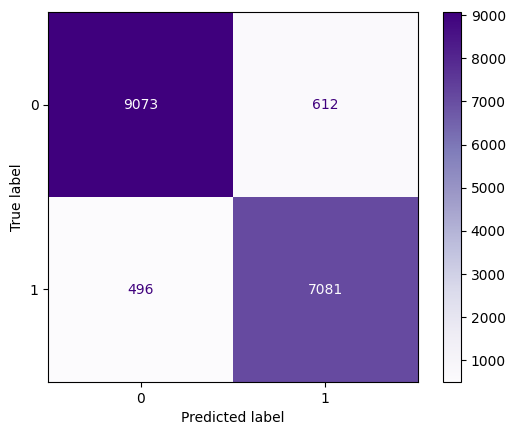

In [12]:
xbg_cm = dx.cm(y_test, y_test_pred_2, cmap="Purples")

**Confusion matrix for model[2] (SPLIT with lookahead depth 2, max depth 6, and lambda 0.005)**

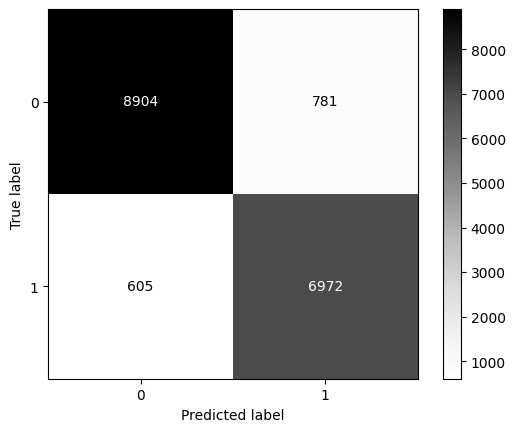

In [13]:
split_cm = dx.cm(y_test, test_prediction_7[0], cmap="Greys")

**Model[2] features list and tree**

In [14]:
display(pd.DataFrame(dx.binarized_features(model_7))["name"])

0                     Online_boarding <= 3.5
1                     Online_boarding <= 4.5
2      Type_of_Travel_Personal Travel <= 0.5
3                           Class_Eco <= 0.5
4               Inflight_wifi_service <= 0.5
5               Inflight_wifi_service <= 3.5
6               Inflight_wifi_service <= 4.5
7     Customer_Type_disloyal Customer <= 0.5
8              Inflight_entertainment <= 3.5
9                    Leg_room_service <= 3.5
10                   On_board_service <= 3.5
Name: name, dtype: object

In [15]:
print(tree_7)

{ feature: 4 [ left child: { prediction: 1, loss: 0.002058142563328147 }, right child: { feature: 2 [ left child: { feature: 5 [ left child: { feature: 8 [ left child: { feature: 1 [ left child: { prediction: 0, loss: 0.033169761300086975 }, right child: { prediction: 1, loss: 0.0007312324596568942 }] }, right child: { feature: 7 [ left child: { prediction: 1, loss: 0.004202384036034346 }, right child: { prediction: 0, loss: 0.002792779356241226 }] }] }, right child: { prediction: 1, loss: 0.037398576736450195 }] }, right child: { feature: 6 [ left child: { prediction: 0, loss: 0.02133789099752903 }, right child: { prediction: 1, loss: 0.0 }] }] }] }
